# Notebook for optimising smFISH analysis parameters
## Kate's HIV smFISH images
## Revised: 2022.12.28
1. Optimise Cellpose parameters
2. Optimise Bigfish parameters

In [1]:
# Environment
import os
import time
from skimage.morphology import white_tophat, black_tophat, disk
from scipy import ndimage, misc
import numpy as np
import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
from cellpose import models, io
from cellpose import plot as cplot
import matplotlib.pyplot as plt
import yaml
import pathlib

/opt/miniconda3/envs/bigfish_env/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/opt/miniconda3/envs/bigfish_env/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.f

2022-12-28 14:52:46,047 [INFO] WRITING LOG OUTPUT TO /Users/jefflee/.cellpose/run.log


### Make sure the bigfish version is 0.4.0

In [2]:
bigfish.__version__

'0.4.0'

# 0. Import image

In [5]:
# Import image file
indir = '../../../kate_smfish/rep1/'
file_name = '20221123_221123_smFISH_72hpi_WT_HIV_001.tiff'

img = tifffile.imread(os.path.join(indir, file_name))
print("Image imported: ", os.path.join(indir, file_name))
print("\r shape: {0}".format(img.shape))
print("\r dtype: {0}".format(img.dtype))

Image imported:  ../../../kate_smfish/rep1/20221123_221123_smFISH_72hpi_WT_HIV_001.tiff
 shape: (41, 4, 2048, 2048)
 dtype: uint16


# 1. Optimise Cellpose parameters

In [6]:
# Set up Cellpose parameters
chan = 1
diameter = 375
flow_threshold = 0.9 
median = 30
do_3D = False
gpu = False

Processing:  ../../../kate_smfish/rep1/20221123_221123_smFISH_72hpi_WT_HIV_001.tiff
2022-12-28 14:55:55,528 [INFO] >>>> using CPU
2022-12-28 14:55:55,629 [INFO] ~~~ FINDING MASKS ~~~
2022-12-28 14:55:59,416 [INFO] >>>> TOTAL TIME 3.79 sec
Cellpose done: 34.2 sec


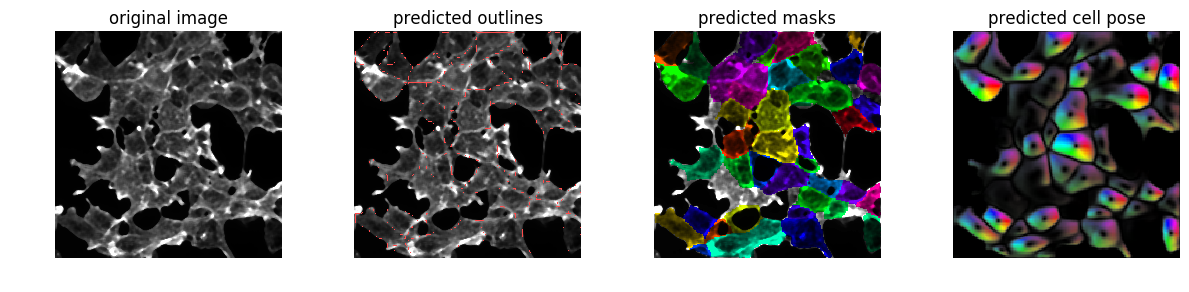

Plotting done: 0.1 sec


In [7]:
# Run cellpose
print("Processing: ", os.path.join(indir, file_name))
t1 = time.time()

seg_img = np.max(img, 0) # max project on the first np axis 
seg_img = ndimage.median_filter(seg_img[chan], size = median) # subset channel and median filter

model = models.Cellpose(gpu=gpu, model_type='cyto')
masks, flows, styles, diams = model.eval(seg_img, channels = [0,0], 
                                         diameter = diameter, do_3D = do_3D, flow_threshold = flow_threshold)

t2 = time.time()
time_elapsed = (t2 - t1)
print('Cellpose done: %s sec' % round(time_elapsed,1))

# Inspect cellpose output
fig = plt.figure(figsize=(12,5))
cplot.show_segmentation(fig, seg_img, masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()

t3 = time.time()
time_elapsed = (t3 - t2) / 60
print('Plotting done: %s sec' % round(time_elapsed,1))

# 2. Optimise bigfish parameters
## 2-1. Get LoG filtred RNA channel image for pre-detection tresholding

In [8]:
# Functions 
## Calculate PSF
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

## Subtract background
def subtract_background(image, radius=5, light_bg=False):
    str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)

In [16]:
# Set up image acquisition parameters
chan = 3
voxel_size_z = 200
voxel_size_yx = 65
Ex = 570
Em = 610
NA = 1.45
RI = 1.45
microscope = 'confocal'

psf_z = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[0]
psf_yx = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[1]
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)

print("PSF and Sigma calculation finished")
print("psf_z = ", psf_z)
print("psf_yx = ", psf_yx)
print("sigma_z = ", sigma_z)
print("sigma_yx = ", sigma_yx)

PSF and Sigma calculation finished
psf_z =  224.03449989716577
psf_yx =  64.62533650879783
sigma_z =  1.1201724994858289
sigma_yx =  0.9942359462891974


In [17]:
# Background subtract RNA image and LoG filter
start_time = time.time()

# Channel subset original image
rna = np.swapaxes(img,0,1)[chan]

print("Image shape ")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

# MIP image for plotting later or for 2D detection
rna_mip = stack.maximum_projection(rna)

# Background subtract
rna_no_bg = []
for z in rna:
    z_no_bg = subtract_background(z)
    rna_no_bg.append(z_no_bg)
rna = np.array(rna_no_bg)

print ("Background subtraction finished ", time.time() - start_time, "sec")

# LoG filter
rna_log = stack.log_filter(rna, sigma)
print ("LoG filter finished ", time.time() - start_time, "sec")


Image shape 
 shape: (41, 2048, 2048)
 dtype: uint16
Background subtraction finished  15.512727975845337 sec
LoG filter finished  58.3601758480072 sec


In [18]:
from PIL import Image
rna_log_max = np.max(rna_log, 0)
im = Image.fromarray(rna_log_max)
im.save('rna_log.tif') # how to add channel name from config to this image filename?

print ("Image saved to working dir! Open it on ImageJ! ", time.time() - start_time, "sec")

Image saved to working dir! Open it on ImageJ!  64.69479084014893 sec


## 2-2 Optimise single-spot detection

In [19]:
## local maximum detection
start_time = time.time()

mask = detection.local_maximum_detection(rna_log, min_distance=sigma)
print ('pre-detect done')

## thresholding
threshold = 12
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print ('threshold done', time.time() - start_time, "sec")

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

pre-detect done
threshold done 14.187219142913818 sec
detected spots
 shape: (23379, 3)
 dtype: int64
 threshold: 12


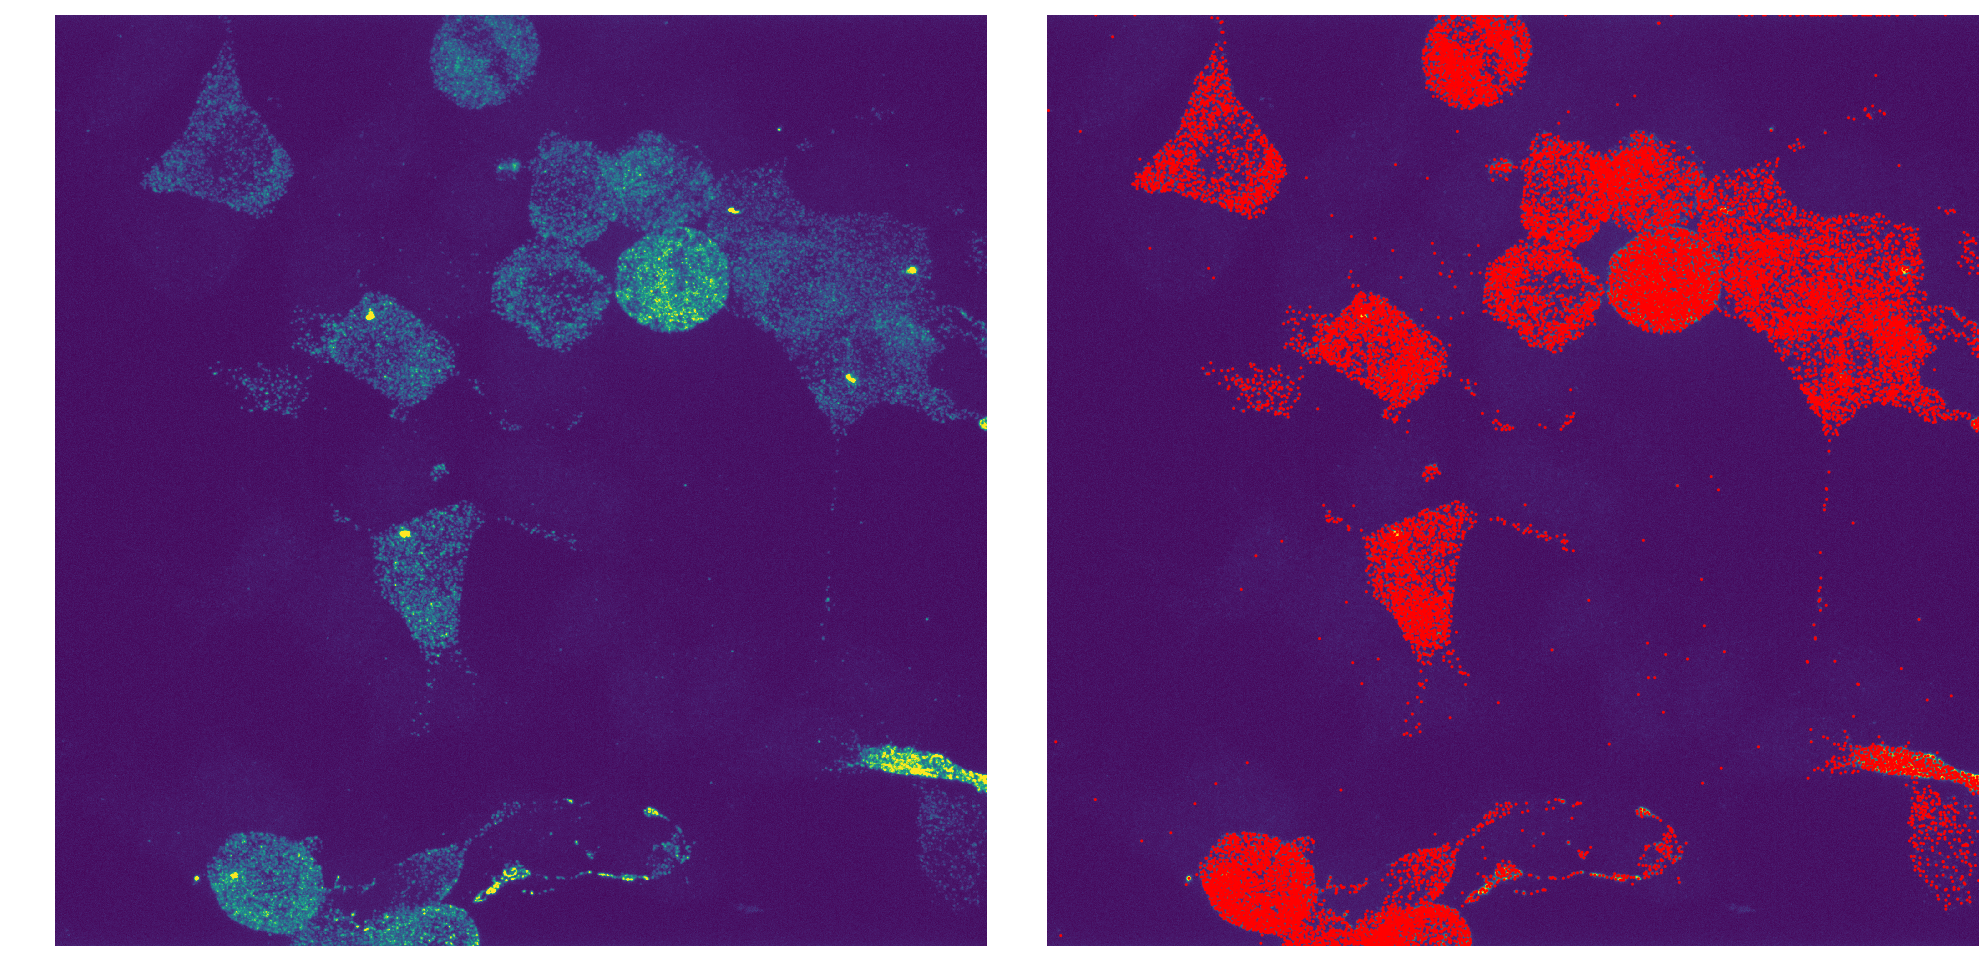

Plotting done  48.14473605155945 sec


In [20]:
# Optional plotting
import bigfish.plot as plot

image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(20, 16), contrast=True)

print ("Plotting done ", time.time() - start_time, "sec")

## 2-3. Decompose cluster

### 2-3-1. Get a reference spot

Denoising done  10.59786605834961 sec
Denoised reference spot for decompose cluster 10.615203142166138 sec

 shape: (5, 5, 5)

 dtype: uint16


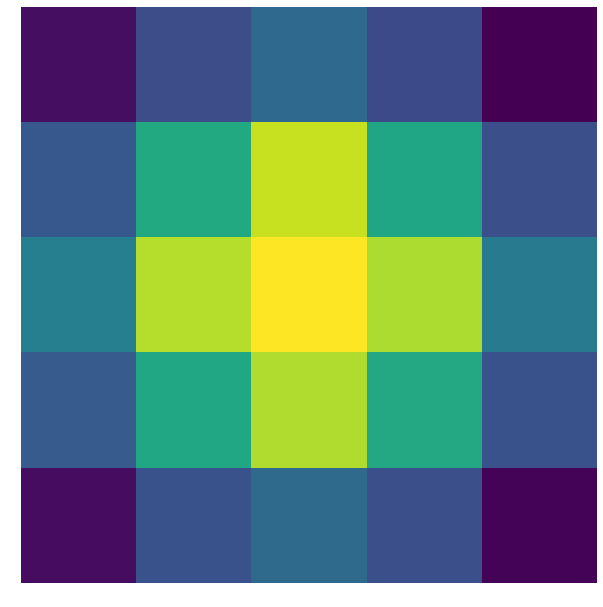

Raw reference spot for use with integrated intensity method 10.788498878479004 sec

 shape: (5, 5, 5)

 dtype: uint16


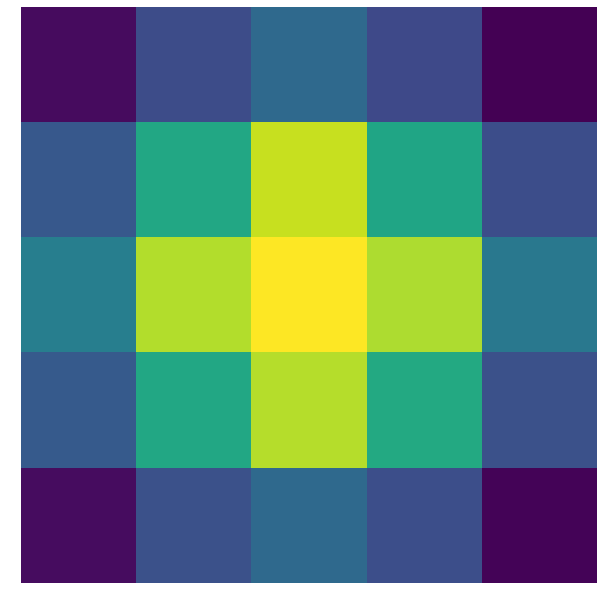

In [12]:
# sigma
start_time = time.time() 

sigma = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
large_sigma = tuple([sigma_ * 5 for sigma_ in sigma])

# denoising
rna_denoised = stack.remove_background_gaussian(rna, large_sigma)

print ("Denoising done ", time.time() - start_time, "sec")

# reference spot from denoised 
reference_spot = detection.build_reference_spot(
rna_denoised,
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
alpha=0.7)

print("Denoised reference spot for decompose cluster", time.time() - start_time, "sec")
print("\r shape: {0}".format(reference_spot.shape))
print("\r dtype: {0}".format(reference_spot.dtype))

plot.plot_reference_spot(reference_spot, rescale=True)

# reference spot from just bgs5 
reference_spot_bgsonly = detection.build_reference_spot(
rna,
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
alpha=0.7)

print("Raw reference spot for use with integrated intensity method", time.time() - start_time, "sec")
print("\r shape: {0}".format(reference_spot_bgsonly.shape))
print("\r dtype: {0}".format(reference_spot_bgsonly.dtype))

plot.plot_reference_spot(reference_spot_bgsonly, rescale=True)


### 2-3-2. Decompose cluster with the reference spot

In [13]:
# sigma
start_time = time.time()
sigma = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
large_sigma = tuple([sigma_ * 5 for sigma_ in sigma])

# denoising
rna_denoised = stack.remove_background_gaussian(rna, large_sigma)

print ("Denoising done ", time.time() - start_time, "sec")

# reference spot
reference_spot = detection.build_reference_spot(
rna_denoised,
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
alpha=0.7)
    
print ('got reference spot', time.time() - start_time, "sec")


Denoising done  10.127805948257446 sec
got reference spot 10.135531902313232 sec


In [14]:
# fit a gaussian function on the reference spot
sigma_z, sigma_yx, amplitude, background = detection.modelize_spot(
reference_spot, voxel_size_z, voxel_size_yx, psf_z, psf_yx)
    
print ('fitted gaussian to ref spot', time.time() - start_time, "sec")

# detect potential cluster regions
cluster_regions, spots_out_cluster, cluster_size = detection.get_clustered_region(
rna_denoised, 
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
beta=1)
    
print('detected potential cluster regions', time.time() - start_time, "sec")
print("my cluster regions numbers are: ", len(cluster_regions))

# precompute gaussian function values
max_grid = max(200, cluster_size + 1)
precomputed_gaussian = detection.precompute_erf(
voxel_size_z, voxel_size_yx, sigma_z, sigma_yx, max_grid)

print ('pre-computed gaussian', time.time() - start_time, "sec")

# gaussian mixtures
spots_in_cluster, _ = detection.fit_gaussian_mixture(
rna_denoised,
cluster_regions,
voxel_size_z,
voxel_size_yx,
sigma_z,
sigma_yx,
amplitude,
background,
precomputed_gaussian)
    
print ('gaussian mixtures done', time.time() - start_time, "sec")

spots_post_decomposition = np.concatenate((spots_out_cluster, spots_in_cluster[:, :3]), axis=0)

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

fitted gaussian to ref spot 10.167240858078003 sec
detected potential cluster regions 11.603939056396484 sec
my cluster regions numbers are:  253
pre-computed gaussian 11.607971906661987 sec
gaussian mixtures done 11.68291974067688 sec
detected spots before decomposition
 shape: (535, 3)
 dtype: int64
detected spots after decomposition
 shape: (709, 3)
 dtype: int64


## 2-4. Separate foci from single molecules

In [15]:
# separate spots from clusters
radius = 350
nb_min_spots = 4
spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition,
        voxel_size_z, voxel_size_yx, radius, nb_min_spots)

print ("foci separation finished ", time.time() - start_time, "sec")

# extract cell level results
image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)
rna_mip = stack.maximum_projection(rna)

fov_results = stack.extract_cell(
    cell_label=masks.astype(np.int64),
    ndim=3,
    rna_coord=spots_post_clustering,
    others_coord={"foci": foci},
    image=image_contrasted,
    others_image={"smfish": rna_mip})

print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype))
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

foci separation finished  185.7787570953369 sec
detected spots after clustering
 shape: (709, 4)
 dtype: int64
detected foci
 shape: (18, 5)
 dtype: int64


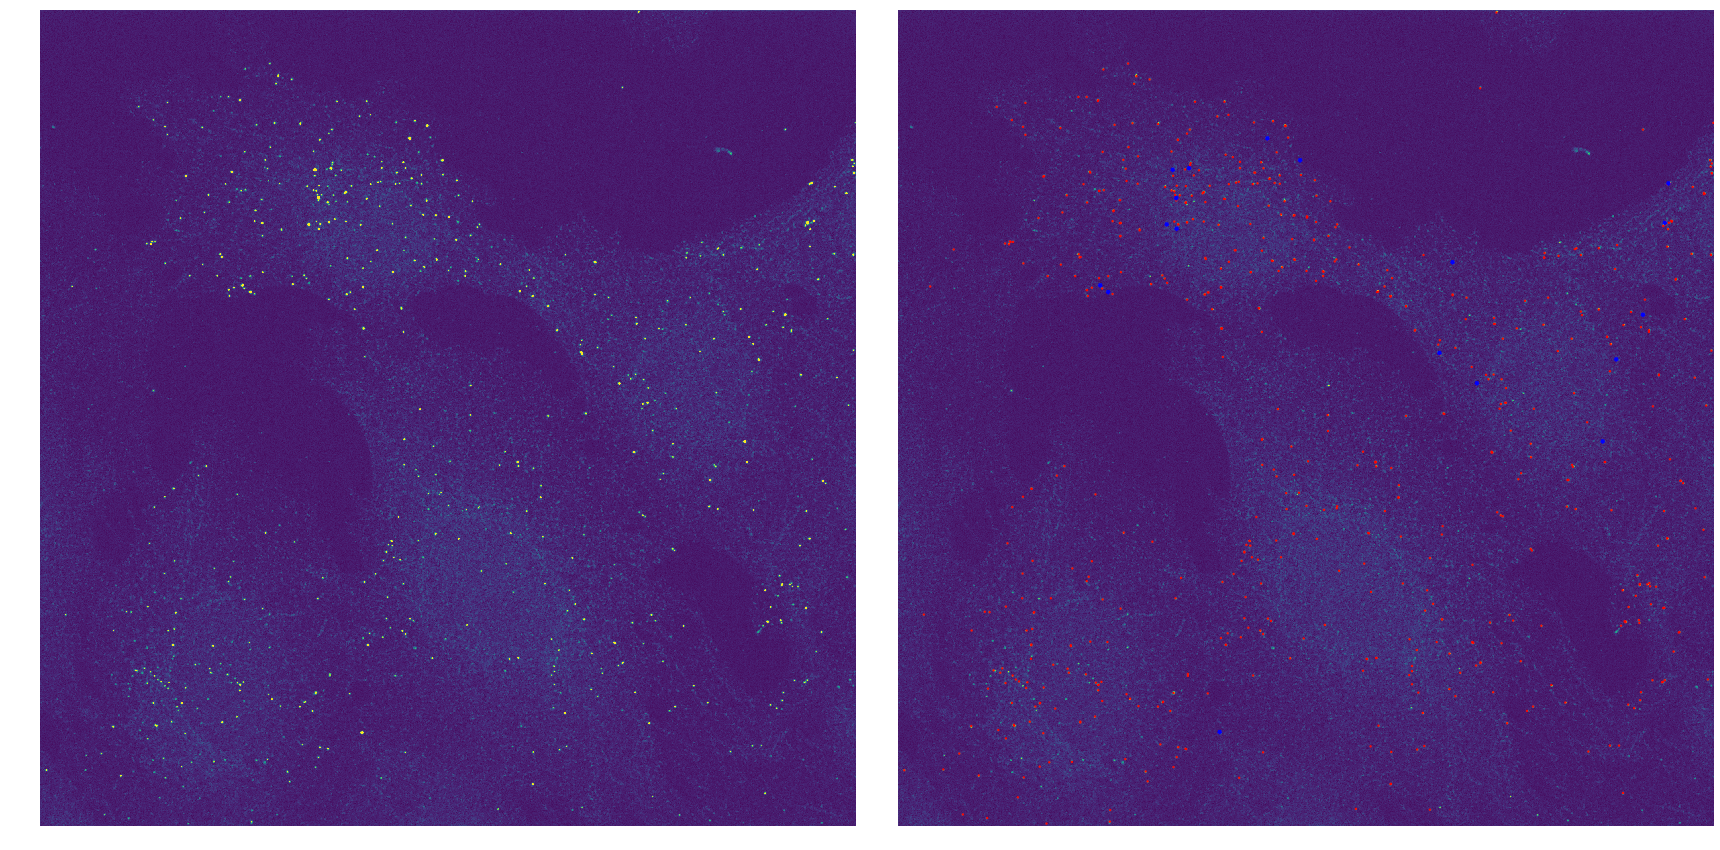

plotting took  3.091732978820801 sec


In [16]:
# Optional plot of spots and foci
start_time = time.time()

(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)

plot.plot_detection(rna_mip, 
                spots=[spots_post_decomposition, foci[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[radius_yx, radius_yx*2], 
                color=["red", "blue"],
                linewidth=[1, 2], 
                fill=[False, True], 
                framesize=(24, 14), 
                contrast=True)

print ("plotting took ", time.time() - start_time, "sec")

In [17]:
## save results
path_output = 'detections'
file_name = file_name

for i, cell_results in enumerate(fov_results):
    path = os.path.join(path_output, (f"{file_name}_ch{chan + 1}_results_cell_{i}.npz"))
    stack.save_cell_extracted(cell_results, path)
    
    

# 3. Read npz files and build a dataframe (if analysing a single image)

## 3-1. Inspect single-cell-level results

0h_6.tif_ch3_results_cell_4.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 


 number of rna 8

 number of foci 0


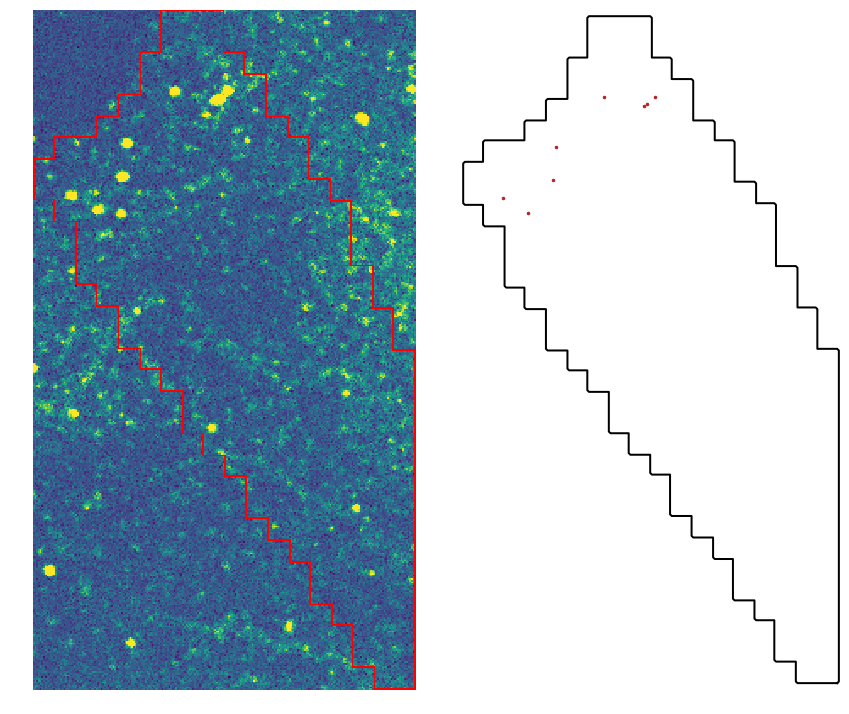

0h_6.tif_ch3_results_cell_3.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 


 number of rna 1

 number of foci 0


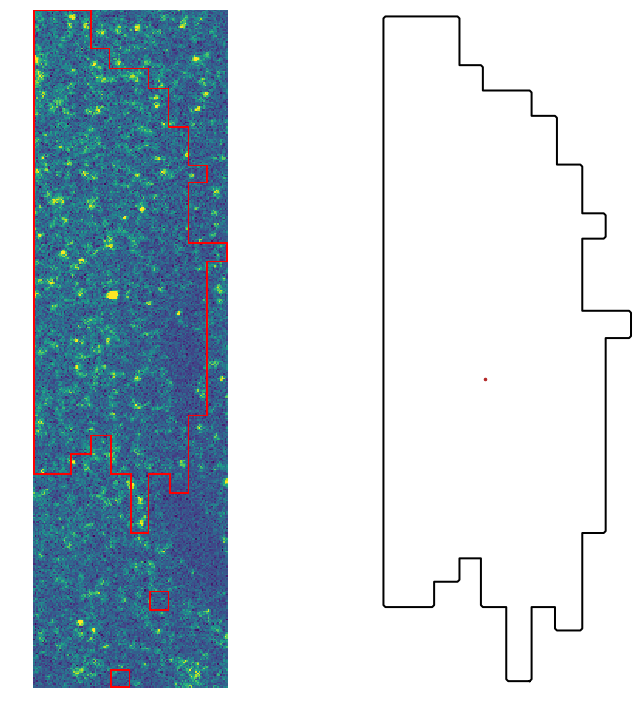

0h_6.tif_ch3_results_cell_2.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 


 number of rna 54

 number of foci 3


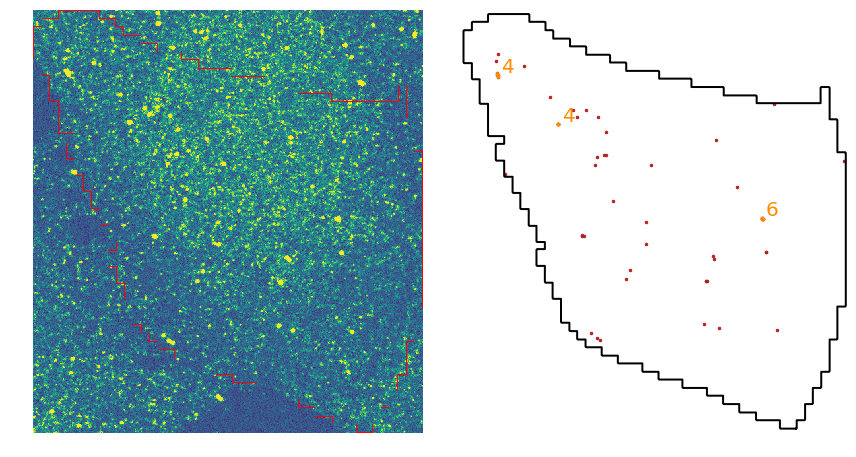

0h_6.tif_ch3_results_cell_0.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 


 number of rna 245

 number of foci 7


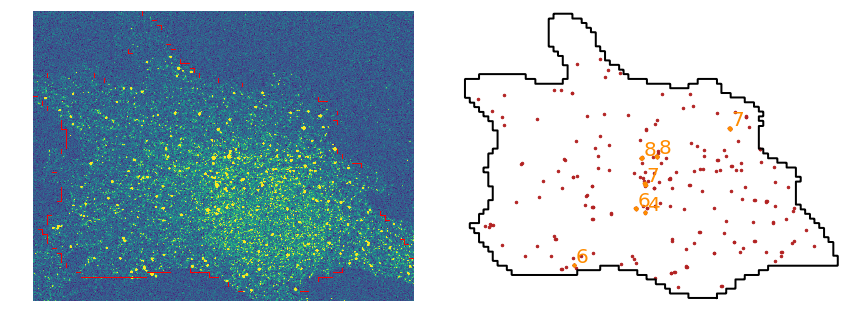

0h_6.tif_ch3_results_cell_1.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 


 number of rna 30

 number of foci 2


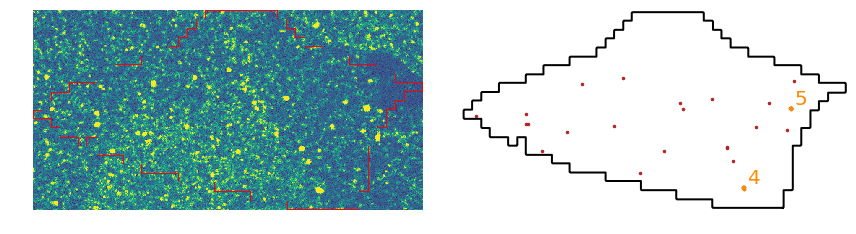

In [18]:
import os
import numpy as np
import bigfish.stack as stack
import bigfish.plot as plot

# load single cell data
indir = 'detections'
keyword = file_name
infiles = [x for x in os.listdir(indir) if x.endswith('.npz') and keyword in x]

def plot_cells():
    # get cell results
    cell_mask = data["cell_mask"]
    cell_coord = data["cell_coord"]
    rna_coord = data["rna_coord"]
    foci_coord = data["foci"]
    image_contrasted = data["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))

    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, rna_coord=rna_coord, 
        foci_coord=foci_coord, image=image_contrasted, 
        cell_mask=cell_mask, framesize=(12, 10),
        contrast=True)
    
for file in infiles:
    path = os.path.join(indir, file)
    print (file)
    data = stack.read_cell_extracted(path, verbose=True)
    rna_coord = data["rna_coord"]
    foci_coord = data["foci"]
    plot_cells()

## 3-2. Build a dataframe

In [19]:
import os
import numpy as np
import pandas as pd

# build a dataframe from .npz files
indir = 'detections'
infiles = [x for x in os.listdir(indir) if x.endswith('.npz')]

# prepare buckets for the data
file_name = []
channel = []
total_vRNAs = []
cytosolic_RNAs = []
repSites = []
mol_per_repSite = []
    
# parse .npz files
for file in infiles:
    data = np.load(os.path.join(indir, file))
    file_name.append(file)
    total_vRNAs.append(data['rna_coord'].shape[0]+np.sum(data['foci'][:,3]))
    cytosolic_RNAs.append(data['rna_coord'].shape[0])
    repSites.append(data['foci'].shape[0])
    mol_per_repSite.append(np.mean(data['foci'][:,3]))
      
    if 'ch3' in file:
        channel.append('ch3')
    if 'ch4' in file:
        channel.append('ch4')
        
# Inspect dataframe
data_tall = pd.DataFrame(list(zip(file_name, channel, total_vRNAs,
                            cytosolic_RNAs, repSites, mol_per_repSite)),
            columns =['file_name', 'channel','total_vRNAs',
                            'cytosolic_RNAs', 'repSites', 'mol_per_repSite'])

data_tall.head(10)
        

/Users/jefflee/miniconda3/envs/bigfish_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jefflee/miniconda3/envs/bigfish_env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


file_name channel  total_vRNAs  cytosolic_RNAs  \
0  0h_6.tif_ch3_results_cell_4.npz     ch3            8               8   
1  0h_6.tif_ch3_results_cell_3.npz     ch3            1               1   
2  0h_6.tif_ch3_results_cell_2.npz     ch3           68              54   
3  0h_6.tif_ch3_results_cell_0.npz     ch3          291             245   
4  0h_6.tif_ch3_results_cell_1.npz     ch3           39              30   

   repSites  mol_per_repSite  
0         0              NaN  
1         0              NaN  
2         3         4.666667  
3         7         6.571429  
4         2         4.500000

In [20]:
# Save as CSV
data_tall.to_csv('final_output.csv')
print('done')

done
